In [1]:
import os, glob, pickle
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
import scipy.sparse as sp          
import numpy.linalg as la         


# SCALING NUMBER
all_energies = []
for f in Path("data/gamma").glob("*.npz"):
    npz = np.load(f, allow_pickle=True)
    for k in npz:
        if not k.startswith("level_scheme_"): continue
        for band in npz[k]:
            all_energies += list(band["nodes"].values())

q95 = np.percentile(all_energies, 95)        # 95‑th percentile


ENERGY_SCALE = q95


# 0, Helpers

def laplacian_positional_encoding(G, pe_dim=8):
    """
    First `pe_dim` non-trivial eigenvectors of the *normalised* graph Laplacian.
    Returns  (N × pe_dim)  torch.FloatTensor.
    """
    A = nx.adjacency_matrix(G).astype(float)         
    deg = np.array(A.sum(1)).flatten()
    D_inv_sqrt = sp.diags(1.0 / np.sqrt(deg + 1e-12))
    L_norm = sp.eye(G.number_of_nodes()) - D_inv_sqrt @ A @ D_inv_sqrt

    # full eigendecomposition is fine for N≈50
    _, vecs = la.eigh(L_norm.toarray())
    pe = vecs[:, 1:pe_dim+1]                         
    return torch.from_numpy(pe).float()

def band_energy(lvl_name, scheme):
    """find absolute energy of lvl_name in any band dict."""
    for band in scheme:
        if lvl_name in band["nodes"]:
            return float(band["nodes"][lvl_name])
    return 0.0

def scheme_to_graph(level_scheme_array):
    G, idx_map, next_idx = nx.DiGraph(), {"grnd": 0}, 1
    for band in level_scheme_array:
        for lvl in band["nodes"]:
            if lvl != "grnd" and lvl not in idx_map:
                idx_map[lvl] = next_idx;  next_idx += 1

    # nodes (store true energy for supervision)
    for name, idx in idx_map.items():
        energy = band_energy(name, level_scheme_array)
        G.add_node(idx, label=name, true_E=energy)

    # directed edges (outer -> inner)
    for band in level_scheme_array:
        for u, v in band["edges"]:
            G.add_edge(idx_map[u], idx_map[v])

    # add reverse edge weights = 0 so adjacency is symmetric for GCN
    G = G.to_undirected()
    return G, idx_map


def build_B_matrix(G: nx.Graph) -> torch.Tensor:
    n   = G.number_of_nodes()
    rows = []
    for u, v in G.edges():         
        row = torch.zeros(n)
        row[u] = -1.0 
        row[v] =  1.0
        rows.append(row)
    return torch.stack(rows, 0)      


# 1, Dataset

class GammaEnergyDataset(Dataset):
    def __init__(self, root: str):
        super().__init__()
        self.samples = []                             

        for f in sorted(Path(root).glob("*.npz")):
            npz = np.load(f, allow_pickle=True)

            # collect matching pairs inside this file
            mats    = [npz[k] for k in sorted(npz) if k.startswith("matrix_")]
            schemes = [npz[k] for k in sorted(npz) if k.startswith("level_scheme_")]

            assert len(mats) == len(schemes), f"{f} has unequal matrices/schemes"

            for mat , scheme in zip(mats, schemes):
                self.samples.append( (mat.astype("float32"), scheme) )

        print(f"GammaEnergyDataset ▶ {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        yy_np, scheme = self.samples[idx]
        yy = torch.from_numpy(yy_np/255.).unsqueeze(0).unsqueeze(0) 
        G , _ = scheme_to_graph(scheme)
        return {"yy": yy, "G": G}


def collate_graph(batch):
    return batch


# 2, Model blocks
class YyEncoder(nn.Module):
    def __init__(self, out_dim: int = 256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,  32, 4, 2, 1), nn.ReLU(inplace=True),  # 512→256
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(inplace=True),  # 256→128
            nn.Conv2d(64,128, 4, 2, 1), nn.ReLU(inplace=True),  # 128→64
            nn.Conv2d(128,256, 4, 2, 1), nn.ReLU(inplace=True),  # 64→32
            nn.Conv2d(256,512, 4, 2, 1), nn.ReLU(inplace=True),  # 32→16
            nn.Conv2d(512,512, 4, 2, 1), nn.ReLU(inplace=True),  # 16→8
            nn.Conv2d(512,512, 4, 2, 1), nn.ReLU(inplace=True),  # 8→4
        )
        self.fc = nn.Linear(512 * 4 * 4, out_dim)

    def forward(self, x):
        b = x.size(0)
        feat = self.conv(x)              # B × 512 × 4 × 4
        return self.fc(feat.view(b, -1)) # B × out_dim


class SimpleGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, H, A_hat):
        return F.relu(self.lin(A_hat @ H))


class GCNStack(nn.Module):
    def __init__(self, in_dim, hid_dim=128, depth=3):
        super().__init__()
        layers = []
        for l in range(depth):
            layers.append(SimpleGCNLayer(
                in_dim if l == 0 else hid_dim,
                hid_dim))
        self.layers = nn.ModuleList(layers)

    def forward(self, H, A_hat):
        for layer in self.layers:
            H = layer(H, A_hat)
        return H                            


class EnergyRegressor(nn.Module):
    def __init__(self, d_ctx=256, d_node=64, gcn_depth=2):
        super().__init__()
        self.yy_enc   = YyEncoder(out_dim=d_ctx)

        self.ctx_mlp  = nn.Linear(d_ctx, d_node)

        self.gcn      = GCNStack(d_node + 8, hid_dim=d_node, depth=gcn_depth)
        self.mlp_energy = nn.Sequential(
            nn.Linear(d_node, 32), nn.GELU(), nn.Linear(32, 1))

        self.ctx_norm = nn.LayerNorm(d_ctx, elementwise_affine=False)

        self.register_buffer("alpha", torch.tensor(0.28)) # constant

    @staticmethod
    def _norm_adj(A):
        A = A + np.eye(A.shape[0])
        deg = A.sum(1)
        D_inv_sqrt = np.diag(1.0 / np.sqrt(deg + 1e-12))
        A_hat = D_inv_sqrt @ A @ D_inv_sqrt
        return torch.from_numpy(A_hat).float()

    def forward(self, yy, G):
        # 1) CNN → context
        c  = self.yy_enc(yy)

        c  = self.ctx_norm(c)               # zero-mean, unit-var
        c = (self.alpha * c).squeeze(0)

        c2 = self.ctx_mlp(c)              # (64,)

        # 2) Laplacian PE
        PE = laplacian_positional_encoding(G, 8).to(c2.device)
        H0 = torch.cat([c2.repeat(G.number_of_nodes(), 1), PE], dim=1)

        # 3) GCN ➜ energy head
        A_hat = self._norm_adj(nx.to_numpy_array(G)).to(H0.device)
        H     = self.gcn(H0, A_hat)
        e     = self.mlp_energy(H).squeeze(1)

        return (e - e[0]) / ENERGY_SCALE


# 3, Loss terms

def loss_node_L1(E_pred, E_true):
    return F.l1_loss(E_pred, E_true)

def loss_projection_Lp(E_pred, E_true, B, p=1):
    gamma_true = B @ E_true
    gamma_pred = B @ E_pred
    return F.l1_loss(gamma_pred, gamma_true) if p == 1 else torch.mean(torch.abs(gamma_pred - gamma_true)**p)**(1/p)

def loss_monotone(E_pred: torch.Tensor,
                  edge_index,
                  E_true: torch.Tensor) -> torch.Tensor:
    """
    Penalise configurations where the predicted energy of the parent falls below the child.
    """
    penalties = []
    for u, v in edge_index:
        if 0 in (u, v):
            continue
        parent, child = (u, v) if E_true[u] > E_true[v] else (v, u)
        penalties.append(E_pred[child] - E_pred[parent])  

    if not penalties:
        return torch.tensor(0., device=E_pred.device)

    return F.relu(torch.stack(penalties)).mean()

def loss_equal_step(E_pred, bands: Dict[int, List[int]]):
    """
    For every band list enforce equal differences between consecutive energies.
    """
    errs = []
    for nodes in bands.values():
        if len(nodes) < 3:                      # need ≥ 3 to define Δ
            continue
        steps = [E_pred[nodes[i+1]] - E_pred[nodes[i]]
                 for i in range(len(nodes)-1)]
        steps = torch.stack(steps)
        errs.append(torch.var(steps))
    if not errs:
        return torch.tensor(0., device=E_pred.device)
    return torch.stack(errs).mean()


def split_into_bands(G: nx.Graph) -> Dict[int, List[int]]:
    """
    Return { band_id : [0, n1, n2, ...] }   (0 always first)
    Nodes reachable from 0 following shortest‑path that
    goes through exactly this band’s chain edges.
    """
    bands = {}
    for u, v in G.edges():
        if 0 in (u, v):
            child = v if u == 0 else u
            bands.setdefault(child, [0]).append(child)
    # extend each band downstream using DFS
    for head in list(bands.keys()):
        current = head
        while True:
            nbrs = [w for w in G.neighbors(current) if w > current]
            if not nbrs:
                break
            current = max(nbrs)          # outermost (by idx)
            bands[head].append(current)
    return bands

/home/tadros0/GRAN really/GRANENV/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch, torch.nn.functional as F,  pickle
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import OneCycleLR

# ── 1) data ───────────────────────────────────────────────────────────
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
full_ds  = GammaEnergyDataset("data/gamma")
n_val    = max(1, int(0.10 * len(full_ds)))
train_ds, val_ds = random_split(
    full_ds, [len(full_ds)-n_val, n_val],
    generator=torch.Generator().manual_seed(42))

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_graph)
val_dl   = DataLoader(val_ds,   batch_size=1, shuffle=False, collate_fn=collate_graph)

# ── 2) model / opt / sched ────────────────────────────────────────────
net  = EnergyRegressor().to(device)
opt  = torch.optim.AdamW(net.parameters(), lr=5e-4, weight_decay=1e-5)

n_epochs        = 200
steps_per_epoch = len(train_dl)
sched = OneCycleLR(
    opt, max_lr=5e-4, epochs=n_epochs, steps_per_epoch=steps_per_epoch,
    pct_start=0.2, div_factor=10, final_div_factor=1e3, anneal_strategy='cos')

λ = (1.0, 0.2, 0.2, 0.1)   # (node, projection, monotone, equal)

# ── 3) bookkeeping ────────────────────────────────────────────────────
best_val, patience, bad = float('inf'), 15, 0
history = {
    # train
    "train_total": [], "train_node": [], "train_proj": [], "train_mono": [], "train_equal": [],
    # val
    "val_total":   [], "val_node":   [], "val_proj":   [], "val_mono":   [], "val_equal":   [],
    # convenience single metric
    "val_L1": []
}

# ── 4) loop ────────────────────────────────────────────────────────────
for epoch in range(1, n_epochs+1):
    # ---- TRAIN --------------------------------------------------------
    net.train()
    sums = {k: 0.0 for k in ("train_total","train_node","train_proj","train_mono","train_equal")}

    for batch in train_dl:
        samp = batch[0]                                  # (leaves batching as-is)
        yy,G = samp["yy"].to(device), samp["G"]

        trueE = torch.tensor([G.nodes[n]['true_E'] for n in G], dtype=torch.float32, device=device)
        gt    = (trueE - trueE[0]) / ENERGY_SCALE

        B     = build_B_matrix(G).to(device)
        edges = list(G.edges())
        bands = split_into_bands(G)

        pred   = net(yy, G)

        L_node = loss_node_L1(pred, gt)
        L_proj = loss_projection_Lp(pred, gt, B)
        L_mono = loss_monotone(pred, edges, gt)
        L_eq   = loss_equal_step(pred, bands)

        loss   = λ[0]*L_node + λ[1]*L_proj + λ[2]*L_mono + λ[3]*L_eq

        opt.zero_grad(); loss.backward(); opt.step(); sched.step()

        sums["train_total"] += loss.item()
        sums["train_node"]  += L_node.item()
        sums["train_proj"]  += L_proj.item()
        sums["train_mono"]  += L_mono.item()
        sums["train_equal"] += L_eq.item()

    b = len(train_dl)
    history["train_total"].append(sums["train_total"]/b)
    history["train_node"] .append(sums["train_node"] /b)
    history["train_proj"] .append(sums["train_proj"] /b)
    history["train_mono"] .append(sums["train_mono"] /b)
    history["train_equal"].append(sums["train_equal"]/b)

    # ---- VALIDATION ---------------------------------------------------
    net.eval()
    vsums = {k: 0.0 for k in ("val_total","val_node","val_proj","val_mono","val_equal")}
    with torch.no_grad():
        for batch in val_dl:
            samp = batch[0]
            yy,G = samp["yy"].to(device), samp["G"]

            trueE = torch.tensor([G.nodes[n]['true_E'] for n in G], dtype=torch.float32, device=device)
            gt    = (trueE - trueE[0]) / ENERGY_SCALE

            B     = build_B_matrix(G).to(device)
            edges = list(G.edges())
            bands = split_into_bands(G)

            pred   = net(yy, G)

            L_node = loss_node_L1(pred, gt)            
            L_proj = loss_projection_Lp(pred, gt, B)
            L_mono = loss_monotone(pred, edges, gt)
            L_eq   = loss_equal_step(pred, bands)

            vtotal = λ[0]*L_node + λ[1]*L_proj + λ[2]*L_mono + λ[3]*L_eq

            vsums["val_total"] += vtotal.item()
            vsums["val_node"]  += L_node.item()
            vsums["val_proj"]  += L_proj.item()
            vsums["val_mono"]  += L_mono.item()
            vsums["val_equal"] += L_eq.item()

    m = len(val_dl)
    history["val_total"].append(vsums["val_total"]/m)
    history["val_node"] .append(vsums["val_node"] /m)
    history["val_proj"] .append(vsums["val_proj"] /m)
    history["val_mono"] .append(vsums["val_mono"] /m)
    history["val_equal"].append(vsums["val_equal"]/m)
    history["val_L1"].append(history["val_node"][-1])

    print(f"ep {epoch:03d} | "
          f"tr {history['train_total'][-1]:.4f} | "
          f"val {history['val_node'][-1]:.4f} | "
          f"lr {sched.get_last_lr()[0]:.2e}")

    # ---- early stop on val L1 ----------------------------------------
    val_l1 = history["val_node"][-1]
    if val_l1 < best_val - 1e-4:
        best_val, bad = val_l1, 0
        torch.save(net.state_dict(), "best_energy_regressor.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early-stopping.")
            break

# ── 5) save history + full validation report ──────────────────────────
with open("loss_history.pkl", "wb") as f:
    pickle.dump(history, f)

net.load_state_dict(torch.load("best_energy_regressor.pt"))
net.eval()

abs_l1, abs_keV = [], []
with torch.no_grad():
    for batch in val_dl:
        samp  = batch[0]
        yy, G = samp["yy"].to(device), samp["G"]
        trueE = torch.tensor([G.nodes[n]['true_E'] for n in G], dtype=torch.float32, device=device)
        gt    = (trueE - trueE[0]) / ENERGY_SCALE
        pred  = net(yy, G)
        l1 = F.l1_loss(pred, gt).item()
        abs_l1.append(l1)
        abs_keV.append(l1 * ENERGY_SCALE)

print("\n─  Final hold-out performance  ─")
print(f"Mean  L1 (scaled) : {np.mean(abs_l1):.4f}")
print(f"Median L1 (scaled): {np.median(abs_l1):.4f}")
print(f"Mean  error (keV) : {np.mean(abs_keV):.1f}")
print(f"Median error (keV): {np.median(abs_keV):.1f}")
print(f"Best  (min)  keV  : {np.min(abs_keV):.1f}")
print(f"Worst (max) keV   : {np.max(abs_keV):.1f}")

GammaEnergyDataset ▶ 1000 samples
ep 001 | tr 0.4149 | val 0.3786 | lr 5.07e-05
ep 002 | tr 0.4052 | val 0.3785 | lr 5.28e-05
ep 003 | tr 0.4205 | val 0.3775 | lr 5.62e-05
ep 004 | tr 0.4072 | val 0.3715 | lr 6.10e-05
ep 005 | tr 0.3926 | val 0.3486 | lr 6.71e-05
ep 006 | tr 0.3520 | val 0.2934 | lr 7.45e-05
ep 007 | tr 0.3092 | val 0.2504 | lr 8.32e-05
ep 008 | tr 0.2918 | val 0.2419 | lr 9.30e-05
ep 009 | tr 0.2893 | val 0.2441 | lr 1.04e-04
ep 010 | tr 0.2877 | val 0.2413 | lr 1.16e-04
ep 011 | tr 0.2867 | val 0.2405 | lr 1.29e-04
ep 012 | tr 0.2811 | val 0.2398 | lr 1.43e-04
ep 013 | tr 0.2816 | val 0.2377 | lr 1.57e-04
ep 014 | tr 0.2842 | val 0.2369 | lr 1.73e-04
ep 015 | tr 0.2882 | val 0.2357 | lr 1.89e-04
ep 016 | tr 0.2883 | val 0.2358 | lr 2.06e-04
ep 017 | tr 0.2775 | val 0.2410 | lr 2.23e-04
ep 018 | tr 0.2757 | val 0.2354 | lr 2.40e-04
ep 019 | tr 0.2788 | val 0.2383 | lr 2.57e-04
ep 020 | tr 0.2782 | val 0.2341 | lr 2.75e-04
ep 021 | tr 0.2869 | val 0.2343 | lr 2.93e-04


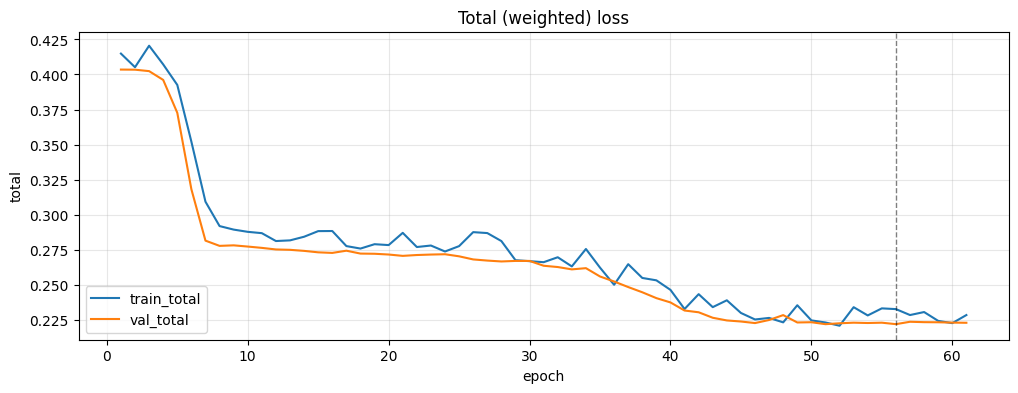

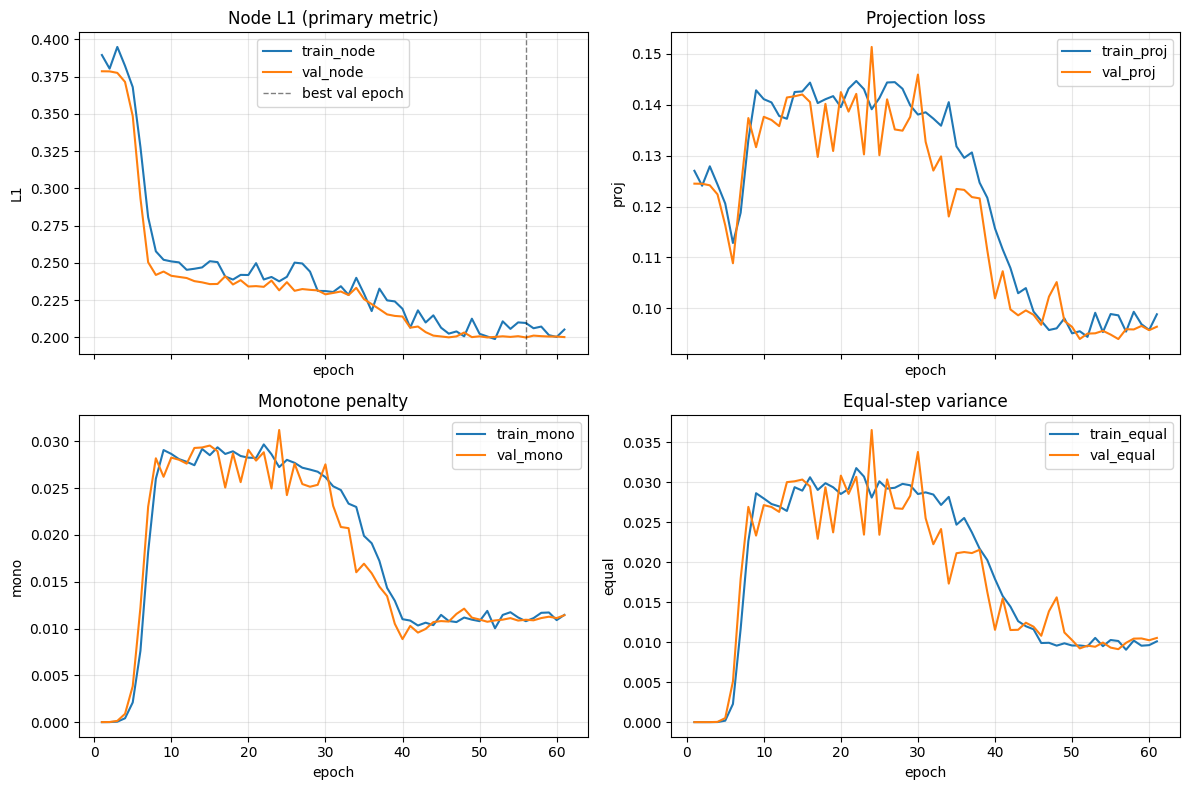

In [3]:
import pickle, numpy as np
import matplotlib.pyplot as plt

with open("loss_history.pkl", "rb") as f:
    history = pickle.load(f)

# checks
required_keys = [
    "train_total","train_node","train_proj","train_mono","train_equal",
    "val_total","val_node","val_proj","val_mono","val_equal"
]
missing = [k for k in required_keys if k not in history]
if missing:
    print("Warning: missing keys in history:", missing)

epochs = np.arange(1, len(history.get("train_total", [])) + 1)
best_idx = int(np.argmin(history.get("val_node", [np.inf]))) if len(history.get("val_node", [])) else None

def plot_pair(ax, key, title, ylabel=None):
    tr = history.get(f"train_{key}", [])
    va = history.get(f"val_{key}", [])
    ax.plot(epochs, tr, label=f"train_{key}")
    ax.plot(epochs, va, label=f"val_{key}")
    if best_idx is not None and key in ("node","total"):
        ax.axvline(best_idx+1, color='k', lw=1, ls='--', alpha=0.5, label="best val epoch" if key=="node" else None)
    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.set_ylabel(ylabel or key)
    ax.grid(alpha=0.3)
    ax.legend()

plt.figure(figsize=(12, 4))
ax = plt.gca()
plot_pair(ax, "total", "Total (weighted) loss")

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
plot_pair(axes[0,0], "node",  "Node L1 (primary metric)", ylabel="L1")
plot_pair(axes[0,1], "proj",  "Projection loss")
plot_pair(axes[1,0], "mono",  "Monotone penalty")
plot_pair(axes[1,1], "equal", "Equal-step variance")
plt.tight_layout()
plt.show()


=== Validation graph 0 ===
 node   label E_true (keV) E_pred (keV) abs-err (keV)
    0    grnd          0.0          0.0           0.0
    1 b1 lvl1       3200.0       3639.0         439.0
    2 b1 lvl2       4017.3       3563.2         454.1
    3 b1 lvl3       5186.4       3364.2        1822.2
    4 b1 lvl4       6715.3       3667.1        3048.2
    5 b1 lvl5       7732.5       4711.3        3021.2
    6 b1 lvl6       8230.0       6204.3        2025.7
    7 b1 lvl7       9087.3       7612.7        1474.6
    8 b1 lvl8      10296.4       9378.7         917.7
    9 b2 lvl1       2016.6       4954.6        2937.9
   10 b2 lvl2       4481.0       5831.2        1350.2
   11 b2 lvl3       7329.2       6106.3        1222.8
   12 b2 lvl4      10569.1       7711.5        2857.6
   13 b3 lvl1        569.5       5590.0        5020.6
   14 b3 lvl2       4169.2       7317.7        3148.5
   15 b3 lvl3       7896.9       8509.6         612.7
   16 b3 lvl4      11752.4      10059.6        1692.8


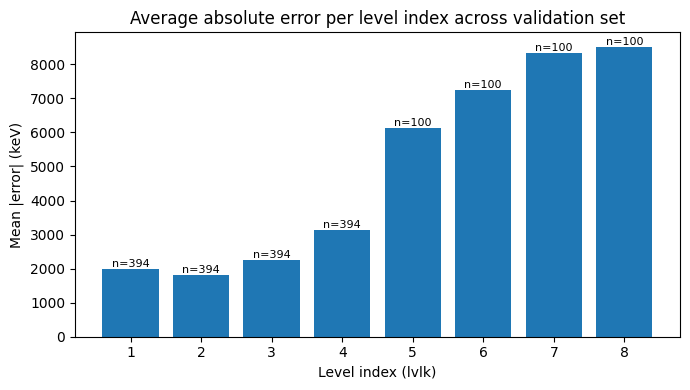

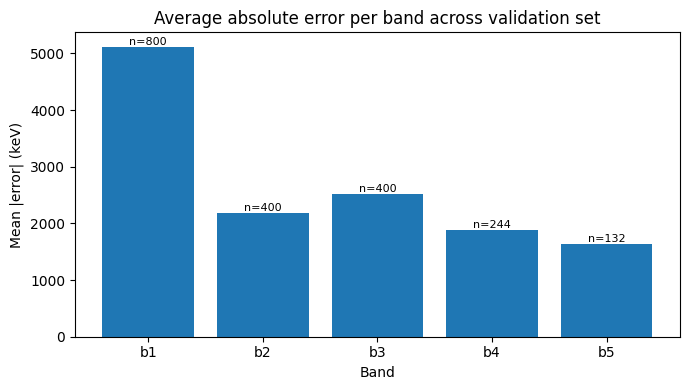


Summary:
Saved per-graph tables to: val_pred_tables/val_XXX.csv
Overall mean graph |error|: 3234.3 keV (over 100 graphs)


In [4]:
# --- Evaluate all validation graphs, save tables, and plot aggregates ----
import os, re, pandas as pd, numpy as np, matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.load_state_dict(torch.load("best_energy_regressor.pt", map_location=device))
net.to(device).eval()

save_dir = "val_pred_tables"
os.makedirs(save_dir, exist_ok=True)

def parse_band_level(label: str):
    """
    Expected like 'b3 lvl2'. Returns (band='b3', level=2).
    Returns (None, None) for 'grnd' or if parsing fails.
    """
    if label is None: return (None, None)
    if label.strip().lower().startswith("grnd"):
        return (None, None)
    m = re.match(r'^\s*(b\d+)\s+lvl(\d+)\s*$', label.strip().lower())
    if m: return (m.group(1), int(m.group(2)))
    return (None, None)

per_level_sum = {}  
per_level_cnt = {}  
per_band_sum  = {}   
per_band_cnt  = {} 

all_graph_means = []   # mean abs error per graph (keV)

for i in range(len(val_ds)):
    sample = val_ds[i]
    yy, G = sample["yy"].to(device), sample["G"]

    with torch.no_grad():
        pred_scaled = net(yy, G).squeeze().detach().cpu()

    true_keV = torch.tensor([G.nodes[n]['true_E'] for n in G]).float().cpu()
    pred_keV = pred_scaled * ENERGY_SCALE + true_keV[0]
    abs_err  = (pred_keV - true_keV).abs()

    rows = []
    for n in G.nodes():
        label = G.nodes[n].get("label", f"L{n}")
        rows.append({
            "node": n,
            "label": label,
            "E_true (keV)": float(true_keV[n]),
            "E_pred (keV)": float(pred_keV[n]),
            "abs-err (keV)": float(abs_err[n]),
        })

        band, lvl = parse_band_level(label)
        if lvl is not None:
            per_level_sum[lvl] = per_level_sum.get(lvl, 0.0) + float(abs_err[n])
            per_level_cnt[lvl] = per_level_cnt.get(lvl, 0)   + 1
        if band is not None:
            per_band_sum[band]  = per_band_sum.get(band, 0.0) + float(abs_err[n])
            per_band_cnt[band]  = per_band_cnt.get(band, 0)   + 1

    df = pd.DataFrame(rows).sort_values("node")   # sort by node index
    
    out_csv = os.path.join(save_dir, f"val_{i:03d}.csv")
    df.to_csv(out_csv, index=False)

    all_graph_means.append(df["abs-err (keV)"].mean())

    # (optional)
    if i < 2:
        print(f"\n=== Validation graph {i} ===")
        print(df.to_string(index=False, 
                           formatters={"E_true (keV)": "{:.1f}".format,
                                       "E_pred (keV)": "{:.1f}".format,
                                       "abs-err (keV)": "{:.1f}".format}))
        print(f"Graph mean |error| = {df['abs-err (keV)'].mean():.1f} keV")

# ---- avg error per level index (lvl1..N) -------------------
levels_sorted = sorted(per_level_cnt.keys())
avg_err_by_level = [per_level_sum[L]/per_level_cnt[L] for L in levels_sorted]
counts_by_level  = [per_level_cnt[L] for L in levels_sorted]

plt.figure(figsize=(7,4))
plt.bar(levels_sorted, avg_err_by_level)
for x, y, c in zip(levels_sorted, avg_err_by_level, counts_by_level):
    plt.text(x, y, f"n={c}", ha='center', va='bottom', fontsize=8, rotation=0)
plt.xlabel("Level index (lvlk)")
plt.ylabel("Mean |error| (keV)")
plt.title("Average absolute error per level index across validation set")
plt.tight_layout()
plt.show()

# ---- avg error per band (b1..bK) ---------------------------
bands_sorted = sorted(per_band_cnt.keys(), key=lambda b: int(re.findall(r'\d+', b)[0]) if re.findall(r'\d+', b) else 999)
avg_err_by_band = [per_band_sum[b]/per_band_cnt[b] for b in bands_sorted]
counts_by_band  = [per_band_cnt[b] for b in bands_sorted]

plt.figure(figsize=(7,4))
plt.bar(bands_sorted, avg_err_by_band)
for x, y, c in zip(bands_sorted, avg_err_by_band, counts_by_band):
    plt.text(x, y, f"n={c}", ha='center', va='bottom', fontsize=8)
plt.xlabel("Band")
plt.ylabel("Mean |error| (keV)")
plt.title("Average absolute error per band across validation set")
plt.tight_layout()
plt.show()

print("\nSummary:")
print(f"Saved per-graph tables to: {save_dir}/val_XXX.csv")
print(f"Overall mean graph |error|: {np.mean(all_graph_means):.1f} keV (over {len(all_graph_means)} graphs)")